<a href="https://colab.research.google.com/github/Crispyjones7387/COVID19-Analysis/blob/master/NLP-Analysis/NLP_COVID19_Research_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=4cd7ce14df180129f527b60659b278aa9529230e3046e259229210f1a5ec831d
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ajr06_1/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [5]:
import pandas as pd
pd.options.display.max_colwidth = 100
import regex as re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import collections
from nltk.util import ngrams   
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from heapq import nlargest
import en_core_web_lg
nlp = en_core_web_lg.load()
nlp.max_length = 1800000 
import glob
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
#!pip install -q kaggle
!wget 'https://storage.googleapis.com/kaggle-data-sets/551982/1040416/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1585979409&Signature=gA5G%2FFbgkljwZDf23gIqeUXgUskwlf76XnxX5e7tmCAVPL0eTiGJAI7vfC%2B3Bdy9eVKk7y5t%2FCcguUpPizRIvK4Y%2Fp3L%2FLYBjTknWFPp8tPEANVusOqtp%2FWpfsYZ5zZJBclnQNUGPW1VfBphivsL%2FAcJVhZDfxCTy1XWoEKKuIQTcIaMwEseBo6RiwWPsYbJXogSbQPzShDf8Lj5Qj4kj4dMZlzBmLgiOfflXt%2BLoh4v5JTNESv7UUQlBngqUTWMk5apOmRF6icUTjvTw6tjmJgYcLGpliFltGpZBoZMgovdtp8lQhr1wp%2BfOSwaXsXESjelpcFUbTIId2m4T2%2FSlg%3D%3D&response-content-disposition=attachment%3B+filename%3DCORD-19-research-challenge.zip'

/bin/bash: response-content-disposition=attachment%3B+filename%3DCORD-19-research-challenge.zip: command not found
--2020-04-01 05:52:02--  https://storage.googleapis.com/kaggle-data-sets/551982/1040416/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-04-01 05:52:02 ERROR 403: Forbidden.



In [23]:
!unzip papers.zip -d COVID-19-research

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19-research/custom_license/custom_license/df46bf0f02a7a1acdb3792013774d7efe6eef372.json  
  inflating: COVID-19-research/custom_license/custom_license/df47877316cb0e933f51e875c1c12d881fd8a42f.json  
  inflating: COVID-19-research/custom_license/custom_license/df47fa724847c5be964d032813df7052644bf40d.json  
  inflating: COVID-19-research/custom_license/custom_license/df4867d3b761e4297d2537702167dc75fb4e4760.json  
  inflating: COVID-19-research/custom_license/custom_license/df4e7d832ca277b5ad96b3269411936bb2f9a49f.json  
  inflating: COVID-19-research/custom_license/custom_license/df54b21db0cc3854ff4f1fd272de543afdcfb6b1.json  
  inflating: COVID-19-research/custom_license/custom_license/df575877c24a5472622f80f0c841c78afab7c017.json  
  inflating: COVID-19-research/custom_license/custom_license/df579575e205bcb94b108aaafb35adbdbb0ad36b.json  
  inflating: COVID-19-research/custom_license/custom_license/df5c297cca7c3832

In [24]:
# Metadata contains a number of columns related to the papers
metaDF = pd.read_csv('COVID-19-research/metadata.csv', usecols = ['title','abstract','authors'])

# Papers are in the form of json files saved under different folders
json_files = glob.glob('COVID-19-research/**/*.json', recursive=True)
len(json_files)

33375

In [0]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            # Adding in list    
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

In [26]:
# Creating a pandas dataframe for papers

paper_dict = {'paper_id': [], 'abstract': [], 'body_text': []}

for i, entry in enumerate(json_files):
    # For viewing the progress
    if i % (len(json_files) // 10) == 0:
        print(f'Processing index: {i} of {len(json_files)}')
    # Loading content of json files
    content = FileReader(entry)
    paper_dict['paper_id'].append(content.paper_id)
    paper_dict['abstract'].append(content.abstract)
    paper_dict['body_text'].append(content.body_text)
    
papers = pd.DataFrame(paper_dict, columns=['paper_id', 'abstract', 'body_text'])
papers = pd.merge(papers, metaDF, how = 'left')

Processing index: 0 of 33375
Processing index: 3337 of 33375
Processing index: 6674 of 33375
Processing index: 10011 of 33375
Processing index: 13348 of 33375
Processing index: 16685 of 33375
Processing index: 20022 of 33375
Processing index: 23359 of 33375
Processing index: 26696 of 33375
Processing index: 30033 of 33375
Processing index: 33370 of 33375


In [27]:
papers.head(5)

,paper_id,abstract,body_text,title,authors
0,8884a33d015cfe35ba1d0df44c0cc33c8e5a23c1,,"Fibrotic diseases are major causes of mortality and morbidity worldwide, leading to a serious ec...",NaN,NaN
1,2a17719f2c1d211a651060441bda8bc1c052e2aa,"Linear motifs are short, evolutionarily plastic components of regulatory proteins and provide lo...","Short linear motifs (SLiMs, LMs or MiniMotifs) are regulatory protein modules characterized by t...",NaN,NaN
2,6ae4586f198b9710e0285939e265149fbdb3bdab,,T he major challenge in regard to influenza surveillance and management is the propensity of the...,NaN,NaN
3,174f63ff45fc7bbecf0f559200761ad76691b6fb,"Cassiae semen (Leguminosae), a well-known traditional Chinese medicine, has been used for a numb...","Cassiae semen, also known as ʻJuemingziʼ in Chinese, is the dry and mature seed of Cassia obtusi...",NaN,NaN
4,11a6f813fa996f0baa670ecc66875602f971eef1,"in one case, whereas Pneumocystis jiroveci was identified as a co-pathogen in one cMV-infected p...","Severe combined immunodeficiency (SCID) is a group of inherited, genetically heterogeneous disor...",NaN,NaN


In [0]:
# Deleting variables which won't be of use further
del metaDF
del json_files

In [0]:
# Function to filter papers containing specific words in abstract
def filter_papers(word_list):
    papers_id_list = []
    for i, row in papers.iterrows():
        if all(x in row.body_text.lower() for x in word_list):
            papers_id_list.append(row.paper_id)
    return papers_id_list

In [30]:
# Using only papers talking about coronavirus
covidPaperIDs = filter_papers(["coronavirus"])
print("\nNumber of papers containing 'coronavirus' = ", len(covidPaperIDs))
papers = papers.loc[papers['paper_id'].isin(covidPaperIDs)]


Number of papers containing 'coronavirus' =  18383


In [31]:
# Creating a new dataframe containing content to be processed with NLP
papersData = papers.loc[:,['paper_id', 'abstract', 'body_text']]
# Merging abstract and body text
papersData.abstract += '\n' + papersData.body_text
# Renaming the new column as content
papersData.drop('body_text', axis = 1, inplace = True)
papersData.rename(columns = {'abstract':'content'}, inplace = True)
papersData.head()

,paper_id,content
4,11a6f813fa996f0baa670ecc66875602f971eef1,"in one case, whereas Pneumocystis jiroveci was identified as a co-pathogen in one cMV-infected p..."
6,6e99aa3d7287b2e04d3c2a975ba94212158ac45c,"\nThe purpose of this study was to investigate which pacing modality (VVI, VVIR, or VDD) most cl..."
8,83303635687128ac583152565ba1d7e29540f2af,Infection and Drug Resistance Dovepress submit your manuscript | www.dovepress.com Dovepress 232...
9,b7d7db5b12584c5fab0c2244a27d0653d8a59f7d,"In this review, we report that the receptor of mouse hepatitis virus (MHV), carcinoembryonic ant..."
11,949ec05f3fbd741cc6c4a08b2bcffdaa3d479866,\nProtein therapeutics are the fastest-growing class of US Food and Drug Administration (FDA)-ap...


In [0]:
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [0]:
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [0]:
STOPWORDS = set(stopwords.words('english'))
# Adding new stopwords which are not relevant
STOPWORDS |= set(['title','abstract','preprint','biorxiv','author','copyright','holder','https','license','et','al','may',
                  'also','medrxiv','granted','reuse','rights','used','reserved','peer','holder','figure','fig','table'])
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [0]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [37]:
def clean_text(col):
    print('Converting to lower case...')
    papersData[col]= papersData[col].str.lower()
    print('Removing /n characters...')
    papersData[col]= papersData[col].apply(lambda x: x.replace('\n', ' '))
    print('Removing urls...')
    papersData[col]= papersData[col].apply(lambda text: remove_URL(text))
    print('Removing punctuations...')
    papersData[col]= papersData[col].apply(lambda text: remove_punctuations(text))
    print('Removing the stopwords...')
    papersData[col]= papersData[col].apply(lambda text: remove_stopwords(text))
    print('Lemmatization of text...')
    papersData[col]= papersData[col].apply(lambda text: lemmatize_words(text))
    print('Removing digits...')
    papersData[col]= papersData[col].map(lambda x: re.sub(r'\d+', '', x))
    
clean_text('content')

Converting to lower case...
Removing /n characters...
Removing urls...
Removing punctuations...
Removing the stopwords...
Lemmatization of text...
Removing digits...


WORD CLOUD

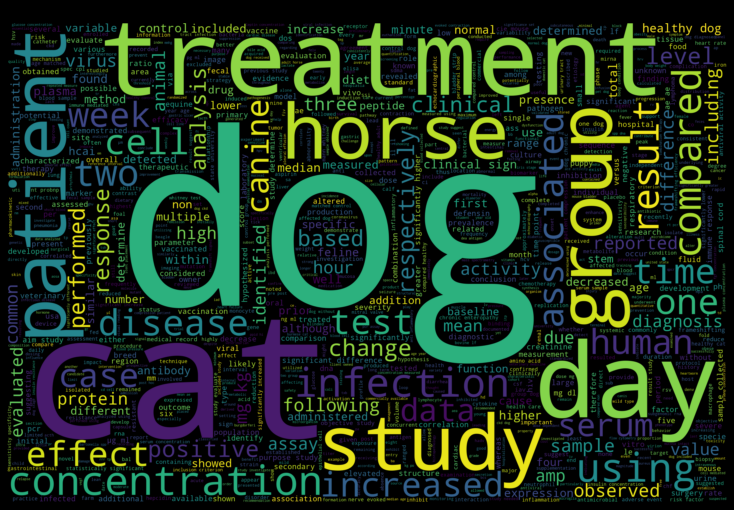

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
contentCorpus = papersData.content.values
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      background_color = 'black',
                      max_words=1000).generate(str(contentCorpus))
fig = plt.figure(figsize = (10, 10),
                 facecolor = 'k',
                 edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Content Corpus')
plt.show()


Extract common 3 phrases

In [0]:
# Tokenizing the entire abstracts available in all papers
all_text = ' '.join(str(word) for word in papersData.content.values) 
tokens = word_tokenize(all_text)

# Listing most common n-grams 
ng3 = ngrams(tokens, 3)
ng3 = collections.Counter(ng3)
ng3.most_common(20)

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words = 'english', sublinear_tf=True)
    matrix = tfidf_vectorizer.fit_transform(data)
    return matrix, tfidf_vectorizer

def sentence_score(sentence: str, word_scores: dict):
    words = sentence.split()
    if len(words) < 50:
        score = sum([word_scores.get(w.lower(),0) for w in words])
    else:
        score=0
    return score

def occurrences(text, word): 
    ctr = 0
    tokens = text.split(" ") 
    for i in range(len(tokens)): 
        if (word == tokens[i].lower()): 
           ctr += 1
    return ctr  


def summarize(paper_id):
    papertext = papers[papers.paper_id == paper_id].body_text
    list_corpus = list(papertext)
    tfidf_matrix, tfidf_vectorizer = tfidf(list_corpus)
    
    # Creating a dataframe with the words scores
    word_scores_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names())   
    word_scores = dict(zip(list(word_scores_df.columns), list(word_scores_df.iloc[0])))  

    # Split into sentences and replacing irrelevant characters
    sentences_list = [nlp(s) for s in list(papertext.str.replace('\n', '.').replace('\r', '.'))]
    sentences_list = str(sentences_list[0]).split('.')

    # Assign scores and join the top sentences into the final summary
    sentences_scores = {}
    for s in sentences_list:
        sentences_scores[s] = sentence_score(s, word_scores)

    top_sentences = nlargest(5, sentences_scores, key=sentences_scores.get)
    top_sentences = [s for s in top_sentences ]
    summary = '. '.join(top_sentences)
        
    return summary

In [0]:
    
    df_table = pd.DataFrame(columns = ["paper_id","word_ctr","summary"])

    rqd_paperids = filter_papers([search_word,"ncov"])
    occur = []
    summaries = []
    
    for paperid in rqd_paperids:
        papertext = papersData.content[papersData.paper_id == paperid]
        occur.append(occurrences(papertext.values[0],search_word))
    
    df_table.paper_id = rqd_paperids
    df_table.word_ctr = occur
    
    df_table.sort_values(by = "word_ctr", ascending = False, inplace = True)
    df_table = df_table[:5]

    for paperid in list(df_table.paper_id):
        summaries.append(summarize(paperid))
    df_table.summary = summaries
    #df_table.drop("word_ctr", axis=1, inplace = True)
    
    return df_table

pd.options.display.max_colwidth = 1500

Display top 5 papers with the given term as query

In [0]:
df1 = related_papers("chloroquine")
df1